## Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Load the datasets
red_wine = pd.read_csv("wine+quality/winequality-red.csv", sep=";")
white_wine = pd.read_csv("wine+quality/winequality-white.csv", sep=";")

### Empirical Estimation in SESSA:
<b>SESSA</b> relies on empirical methods to analyze the structure of data. The <b>ECDF</b> is one such empirical method used to estimate the cumulative distribution of a dataset.

The ECDF provides a non-parametric way to understand the distribution of a feature, which is crucial for identifying patterns, outliers, and the overall structure of the data.

In [3]:
def plot_ecdf(data, feature, wine_type):
    """
    Plot the ECDF of a feature for a given dataset.
    """
    sorted_vals = np.sort(data[feature])
    yvals = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)

    plt.figure(figsize=(8, 5))
    plt.plot(sorted_vals, yvals, marker=".", linestyle="none", label=f"{wine_type} Wine", color="red" if wine_type == "Red" else "blue")
    plt.xlabel(feature)
    plt.ylabel("ECDF")
    plt.title(f"ECDF of {feature} ({wine_type} Wine)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_ecdf(red_whine, "pH", "Red")

In [5]:
def compute_kde(data, feature):
    """
    Compute Kernel Density Estimation (KDE) for a given feature.
    """
    kde = gaussian_kde(data[feature])
    return kde

In [7]:
def filter_data(data, feature_x, feature_y, lower_percentile=10, upper_percentile=80):
    """
    Filter the data to retain the middle range (e.g., 10th to 80th percentile).
    """
    lower_x, upper_x = np.percentile(data[feature_x], [lower_percentile, upper_percentile])
    lower_y, upper_y = np.percentile(data[feature_y], [lower_percentile, upper_percentile])
    filtered_data = data[
        (data[feature_x] >= lower_x) & (data[feature_x] <= upper_x) &
        (data[feature_y] >= lower_y) & (data[feature_y] <= upper_y)
    ]
    return filtered_data, (lower_x, upper_x), (lower_y, upper_y)

In [8]:
def perform_kmeans(data, feature_x, feature_y, n_clusters=5):
    """
    Perform K-Means clustering on the standardized data.
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[[feature_x, feature_y]])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    data["KMeans_Cluster"] = kmeans.fit_predict(scaled_data)
    return data

In [9]:
def perform_agglomerative(data, feature_x, feature_y, n_clusters=3):
    """
    Perform Agglomerative clustering on the standardized data.
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[[feature_x, feature_y]])
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    data["Agglomerative_Cluster"] = agglo.fit_predict(scaled_data)
    return data, scaled_data

In [10]:
def plot_kde(kde, feature, lower, upper, wine_type):
    """
    Plot the Kernel Density Estimation (KDE) for a feature.
    """
    x_vals = np.linspace(lower, upper, 1000)
    plt.plot(x_vals, kde(x_vals), label="KDE", color="blue")
    plt.axvline(lower, color="red", linestyle="--", label=f"{lower_percentile}th Percentile")
    plt.axvline(upper, color="green", linestyle="--", label=f"{upper_percentile}th Percentile")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.title(f"KDE of {feature} ({wine_type} wine)")
    plt.legend()
    plt.grid(True)

In [11]:
def plot_clustering(data, feature_x, feature_y, cluster_column, title, cmap="viridis"):
    """
    Plot clustering results.
    """
    plt.scatter(data[feature_x], data[feature_y], c=data[cluster_column], cmap=cmap, edgecolors="k")
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(title)
    plt.colorbar(label="Cluster")
    plt.grid(True)

In [12]:
def plot_dendrogram(scaled_data, wine_type):
    """
    Plot the dendrogram for Agglomerative clustering.
    """
    linked = linkage(scaled_data, method="ward")
    dendrogram(linked, orientation="top", distance_sort="descending", show_leaf_counts=True)
    plt.title(f"Dendrogram ({wine_type} wine)")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")

In [13]:
def sessa_empirical_estimation_with_agglomerative(data, feature_x, feature_y, wine_type):
    """
    Perform SESSA-like empirical estimation and clustering, including K-Means and Agglomerative Clustering.
    """
    # Step 1: Compute empirical distribution (KDE)
    kde_x = compute_kde(data, feature_x)
    kde_y = compute_kde(data, feature_y)

    # Step 2: Retain a subset of the data (e.g., remove extreme outliers)
    filtered_data, (lower_x, upper_x), (lower_y, upper_y) = filter_data(data, feature_x, feature_y)

    # Step 3: Perform K-Means clustering
    filtered_data = perform_kmeans(filtered_data, feature_x, feature_y, n_clusters=5)

    # Step 4: Perform Agglomerative clustering
    filtered_data, scaled_data = perform_agglomerative(filtered_data, feature_x, feature_y, n_clusters=3)

    # Step 5: Visualize the results
    plt.figure(figsize=(20, 5))

    # Plot KDE for feature_x
    plt.subplot(1, 4, 1)
    plot_kde(kde_x, feature_x, lower_x, upper_x, wine_type)

    # Plot K-Means clustering
    plt.subplot(1, 4, 2)
    plot_clustering(filtered_data, feature_x, feature_y, "KMeans_Cluster", f"K-Means Clustering ({wine_type} wine)", cmap="viridis")

    # Plot Agglomerative clustering
    plt.subplot(1, 4, 3)
    plot_clustering(filtered_data, feature_x, feature_y, "Agglomerative_Cluster", f"Agglomerative Clustering ({wine_type} wine)", cmap="plasma")

    # Plot dendrogram for Agglomerative clustering
    plt.subplot(1, 4, 4)
    plot_dendrogram(scaled_data, wine_type)

    plt.tight_layout()
    plt.show()

    return filtered_data

SESSA-like Analysis for Red Wine:


/var/folders/jr/ht0rtnl55hq80pk016rxvhzw0000gn/T/ipykernel_57086/3458762430.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["KMeans_Cluster"] = kmeans.fit_predict(scaled_data)
/var/folders/jr/ht0rtnl55hq80pk016rxvhzw0000gn/T/ipykernel_57086/1058165568.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Agglomerative_Cluster"] = agglo.fit_predict(scaled_data)


NameError: name 'lower_percentile' is not defined

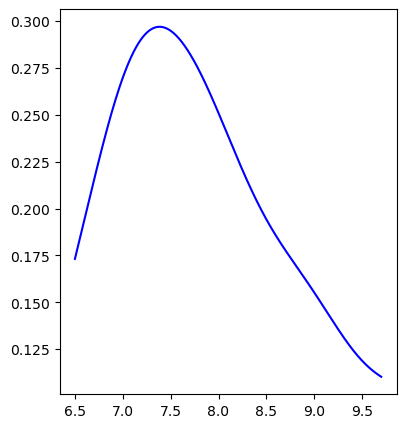

In [15]:
print("SESSA-like Analysis for Red Wine:")
filtered_red_wine = sessa_empirical_estimation_with_agglomerative(red_wine, "fixed acidity", "volatile acidity", "Red")
